In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

gpytorch.functions.use_toeplitz = False
# gpytorch.functions.max_cg_iterations = 100

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=256,
                                                            grid_bounds=[(0, 1)])
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)


likelihood = GaussianLikelihood().cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0

def train():
    for i in range(20):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/20 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()
%time train()

Max iter: 15
(1, 719.0418701171875, 298.03338623046875, 1.0071697235107422)
(2, 257.2044982910156, 45.38168716430664, 1.0055973529815674)
(3, 26.075960159301758, 1.622989296913147, 1.00412917137146)
(4, 1.6595137119293213, 1.1092455387115479, 1.001734972000122)
(5, 865.58837890625, 5.111988544464111, 1.0000094175338745)
(6, 126.16645812988281, 12.616227149963379, 1.0000030994415283)
(7, 2.3471925258636475, 0.7783970832824707, 1.0000030994415283)
(8, 50.962562561035156, 183.74314880371094, 1.0000029802322388)
(9, 824.182861328125, 0.29519200325012207, 1.0000029802322388)
(10, 3.85524320602417, 18.764400482177734, 1.0000028610229492)
(11, 124.75120544433594, 12.071112632751465, 1.0000027418136597)
(12, 865.3500366210938, 8.238243103027344, 1.0000026226043701)
(13, 1.7160308361053467, 1.4575568437576294, 1.0000017881393433)
(14, 9.355184555053711, 2.2314579486846924, 1.000001072883606)
Iter 1/20 - Loss: 1.150
Max iter: 15
(1, 672.0825805664062, 376.46685791015625, 1.6618194580078125)
(2, 

Iter 9/20 - Loss: 0.898
Max iter: 15
(1, 1234.5103759765625, 601.0548095703125, 1.9502822160720825)
(2, 932.7603759765625, 165.15467834472656, 0.9414980411529541)
(3, 132.7288360595703, 1.6766027212142944, 0.4802599251270294)
(4, 8.86193561553955, 0.6902099251747131, 0.2618996202945709)
(5, 61.89504623413086, 310.2454528808594, 0.26110556721687317)
(6, 1630.112548828125, 160.8289031982422, 0.26110461354255676)
(7, 528.2610473632812, 6.005216598510742, 0.2610878646373749)
(8, 78.17997741699219, 18.19144630432129, 0.2610419988632202)
(9, 5.455816745758057, 38.97500228881836, 0.2610417604446411)
(10, 1709.064453125, 22.643138885498047, 0.2610410451889038)
(11, 509.3004150390625, 7.597535610198975, 0.26102757453918457)
(12, 9.293207168579102, 5.76690673828125, 0.2610270380973816)
(13, 402.6080627441406, 649.4227294921875, 0.261027067899704)
(14, 1387.41015625, 28.360107421875, 0.261027067899704)
Iter 10/20 - Loss: 0.865
Max iter: 15
(1, 1822.739990234375, 138.0567626953125, 3.9349384307861

Max iter: 15
(1, 2513.7646484375, 573.3278198242188, 7.360666275024414)
(2, 1256.306640625, 516.7821655273438, 1.2475471496582031)
(3, 788.165283203125, 190.90481567382812, 0.5387598872184753)
(4, 208.7618865966797, 3.521822929382324, 0.2337871789932251)
(5, 3.447756290435791, 16.755651473999023, 0.09248141944408417)
(6, 2741.62646484375, 219.18603515625, 0.08872386813163757)
(7, 66.93698120117188, 215.48069763183594, 0.08860975503921509)
(8, 1373.086669921875, 76.03572082519531, 0.08856409788131714)
(9, 142.52621459960938, 212.72230529785156, 0.08846287429332733)
(10, 354.2091369628906, 1.958044171333313, 0.08845128864049911)
(11, 124.97817993164062, 129.30319213867188, 0.08693913370370865)
(12, 2751.01611328125, 79.927978515625, 0.08692057430744171)
(13, 69.27095031738281, 299.45147705078125, 0.08692025393247604)
(14, 1344.7733154296875, 8.795326232910156, 0.08692002296447754)
Iter 19/20 - Loss: 0.013
Max iter: 15
(1, 2519.43701171875, 466.99169921875, 4.054183006286621)
(2, 1450.416

Max iter: 100
(1, 2573.5771484375, 257.64276123046875, 10.0536470413208)
(2, 436.15802001953125, 283.8747253417969, 0.9996147155761719)
(3, 836.3825073242188, 531.5020751953125, 0.43196097016334534)
(4, 939.786865234375, 71.74100494384766, 0.2579900026321411)
(5, 47.80158615112305, 5.316776275634766, 0.10421948879957199)
(6, 162.94717407226562, 617.9996948242188, 0.06188209727406502)
(7, 2457.873046875, 5.789039611816406, 0.06168578937649727)
(8, 32.10258865356445, 130.13905334472656, 0.05714980512857437)
(9, 573.6060180664062, 170.36822509765625, 0.05710262805223465)
(10, 1424.76123046875, 39.6225471496582, 0.056471630930900574)
(11, 439.7821044921875, 772.9266967773438, 0.05580142140388489)
(12, 2338.500244140625, 25.45332908630371, 0.05580103024840355)
(13, 4.3628950119018555, 10.78435230255127, 0.055793002247810364)
(14, 39.679161071777344, 85.11856079101562, 0.0558212585747242)
(15, 1293.4166259765625, 349.3929748535156, 0.05578932911157608)
(16, 785.5825805664062, 310.59490966796

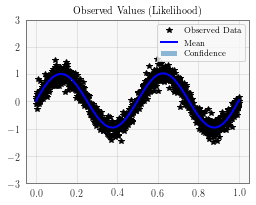

In [5]:
gpytorch.functions.max_lanczos_iterations = 100

model.train()
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 51)).cuda()
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
    ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')